In [ ]:
import time
import torch
import pandas as pd
import seaborn as sns
from torch import nn
from torch.optim.lr_scheduler import ReduceLROnPlateau
from collections import Counter
from torchvision import transforms, datasets, models
import matplotlib.pyplot as plt
import copy


class NeuralNetwork(object):
    # Dictionary of classifier parameters
    __dict_in = {
        'resnet18': 224, 'alexnet': 224,
        'vgg16': 224, 'resnet34': 224,
        'inceptionv3': 299, 'vgg19': 224,
        'mobilenetv2': 224, 'mobilenetv3large': 224,
        'mobilenetv3small': 224, 'resnet152': 224,
        'wideresnet50': 224, 'mnasnet': 224,
    }

    def __init__(self, model_name, optimizer_name,
                 batch_size, epochs, lr=0.001, save_path=None,
                 train_path=None, test_path=None,
                 weights_path=None,):

        self.model_name = model_name
        self.optimizer_name = optimizer_name
        self.batch_size = batch_size
        self.epochs = epochs
        self.lr = lr
        self.save_path = save_path
        self.train_path = train_path
        self.test_path = test_path
        self.weights_path = weights_path
        self.model = None

    def transform_images(self, image_size, mean=(0, 0, 0), std=(1, 1, 1)):
        # Define transformations: 1 to tensor and 2 normalize
        transform_list = [transforms.Resize(image_size),
                          transforms.ToTensor(),
                          transforms.Normalize(mean, std)]

        # Define transform function with a list of parameters
        transform = transforms.Compose(transform_list)

        return transform

    def load_dataset(self, tform):
        # Load Dataset with ImageFolder
        try:
            # ImageFolder automatically converts images to RGB
            train_data = datasets.ImageFolder(self.train_path, transform=tform)
            # Number of train data
            count, data_len = self.getnumber_imagesdataset(train_data)
            num_class = self.getnumber_classes(train_data)

            if self.test_path is not None:
                test_data = datasets.ImageFolder(self.test_path, transform=tform)
            else:
                # Length of splits
                length = len(train_data)
                train_length = int(0.8 * length)
                test_length = length - train_length

                # Split data_set
                train_data, test_data = torch.utils.data.random_split(
                    train_data, [train_length, test_length],
                    generator=torch.Generator().manual_seed(42)
                )

            # Load data as iterable
            train_loader = torch.utils.data.DataLoader(train_data, batch_size=self.batch_size,
                                                       shuffle=True, num_workers=2)
            test_loader = torch.utils.data.DataLoader(test_data, batch_size=self.batch_size,
                                                      shuffle=True, num_workers=2)

            # Dict of loader
            __dict_loader = {
                'train': train_loader,
                'test': test_loader,
            }

            return __dict_loader, count, data_len, num_class

        except FileNotFoundError:
            return None, None, None, None

    def compute_mean_std(self, image_loader):
        # Store pixel sum, square pixel sum, and num of batches
        psum, psum_sq, num_batches = 0, 0, 0
        # For loop through images loaded
        image_loader = image_loader['train']
        try:
            for inputs, _ in image_loader:
                psum += torch.mean(inputs, dim=[0, 2, 3])
                psum_sq += torch.mean(inputs ** 2, dim=[0, 2, 3])
                num_batches += 1
            # Compute mean and std of dataset
            total_mean = psum / num_batches
            total_var = (psum_sq / num_batches) - (total_mean ** 2)
            # Float array must be convert to tensor for speed up calculations
            total_std = torch.sqrt(torch.FloatTensor(total_var))
            total_mean, total_std = tuple(total_mean.tolist()), tuple(total_std.tolist())
            return total_mean, total_std

        except Exception:
            return None, None

    def load_normalized_datset(self, img_size=224):
        tform = self.transform_images(img_size)
        img, _, _, _ = self.load_dataset(tform)
        mean, std = self.compute_mean_std(img)
        tform = self.transform_images(img_size, mean=mean, std=std)
        image_loader, count, data_len, num_class = self.load_dataset(tform)
        mean = tuple(map(lambda x: isinstance(x, float) and round(x, 3) or x, mean))
        std = tuple(map(lambda x: isinstance(x, float) and round(x, 3) or x, std))
        # Dictionary with parameters
        __dict_load = {
            'Number of images in dataset': data_len,
            'Number of images per class': count,
            'Number of classes': num_class,
            'Mean': mean, 'Std': std,
        }

        print('Dataset load and nomalized: Completed\n',
              '\tDataset statistics:\n',
              '\t--------------------\n',
              '\tNumber of images {}\n'.format(data_len),
              '\tNumber of classes: {}\n'.format(num_class),
              '\tNumber of classe-images:\n{}\n'.format(count),
              '\tDataset mean: {}\n'.format(mean),
              '\tDataset std: {}\n'.format(std),
              )
        return image_loader, __dict_load

    @staticmethod
    def getnumber_imagesdataset(data):
        nums= Counter(data.targets)
        data_id = data.class_to_idx
        data_count = dict(zip(data_id.keys(), nums.values()))
        data_count = pd.DataFrame.from_dict(data_count, orient='index',
                       columns=['Number of images'])
        data_len = len(data)
        return data_count, data_len

    @staticmethod
    def getnumber_classes(data):
        data_count = len(data.classes)
        return data_count

    def set_parameter_requires_grad(self):
        if self.weights_path:
            self.model.load_state_dict(torch.load(self.weights_path))
            print('Model status: Pretrained')
            for param in self.model.parameters():
                param.requires_grad = False
        else:
            print('Model status: Not Pretrained')

    def select_model(self, num_classes):
        # Get model name from __init__
        name = self.model_name
        # Check model selected
        if name == r'resnet18':
            self.model = models.resnet18()
            self.set_parameter_requires_grad()
            num_ftrs = self.model.fc.in_features
            self.model.fc = nn.Linear(num_ftrs, num_classes)
        elif name == r'resnet34':
            self.model = models.resnet34()
            self.set_parameter_requires_grad()
            num_ftrs = self.model.fc.in_features
            self.model.fc = nn.Linear(num_ftrs, num_classes)
        elif name == r'resnet152':
            self.model = models.resnet152()
            self.set_parameter_requires_grad()
            num_ftrs = self.model.fc.in_features
            self.model.fc = nn.Linear(num_ftrs, num_classes)
        elif name == r'alexnet':
            self.model = models.alexnet()
            self.set_parameter_requires_grad()
            num_ftrs = self.model.classifier[6].in_features
            self.model.classifier[6] = nn.Linear(num_ftrs, num_classes)
        elif name == r'vgg16':
            self.model = models.vgg16()
            self.set_parameter_requires_grad()
            num_ftrs = self.model.classifier[6].in_features
            self.model.classifier[6] = nn.Linear(num_ftrs, num_classes)
        elif name == r'vgg19':
            self.model = models.vgg19()
            self.set_parameter_requires_grad()
            num_ftrs = self.model.classifier[6].in_features
            self.model.classifier[6] = nn.Linear(num_ftrs, num_classes)
        elif name == r'inceptionv3':
            self.model = models.inception_v3()
            self.set_parameter_requires_grad()
            # Handle the auxilary net
            num_ftrs = self.model.AuxLogits.fc.in_features
            self.model.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
            # Handle the primary net
            num_ftrs = self.model.fc.in_features
            self.model.fc = nn.Linear(num_ftrs, num_classes)
        elif name == r'mobilenetv2':
            self.model = models.mobilenet_v2()
            self.set_parameter_requires_grad()
            num_ftrs = self.model.classifier[1].in_features
            self.model.classifier[1] = nn.Linear(num_ftrs, num_classes)
        elif name == r'mobilenetv3large':
            self.model = models.mobilenet_v3_large()
            self.set_parameter_requires_grad()
            num_ftrs = self.model.classifier[3].in_features
            self.model.classifier[3] = nn.Linear(num_ftrs, num_classes)
        elif name == r'mobilenetv3small':
            self.model = models.mobilenet_v3_small()
            self.set_parameter_requires_grad()
            num_ftrs = self.model.classifier[3].in_features
            self.model.classifier[3] = nn.Linear(num_ftrs, num_classes)
        elif name == r'wideresnet50':
            self.model = models.wide_resnet50_2()
            self.set_parameter_requires_grad()
            num_ftrs = self.model.fc.in_features
            self.model.fc = nn.Linear(num_ftrs, num_classes)
        elif name == r'mnasnet':
            self.model = models.mnasnet1_0()
            self.set_parameter_requires_grad()
            num_ftrs = self.model.classifier[1].in_features
            self.model.classifier[1] = nn.Linear(num_ftrs, num_classes)
        else:
            self.model = None

        print('Model selected: {}'.format(name))

    def select_optimizer(self):

        # Get optimizer name and initial learning rate
        opt_name, lr = self.optimizer_name, self.lr
        # Gather information about parameters to update
        params_to_update = self.model.parameters()
        print("Params to learn:")
        if self.weights_path:
            params_to_update = []
            for name, param in self.model.named_parameters():
                if param.requires_grad == True:
                    params_to_update.append(param)
                    print("\t", name)
        else:
            for name, param in self.model.named_parameters():
                if param.requires_grad == True:
                    print("\t", name)

        # Select optimizer by name
        if opt_name == 'Adam':
            optimizer = torch.optim.Adam(params_to_update, lr=lr)
        elif opt_name == 'SGD':
            optimizer = torch.optim.SGD(params_to_update, lr=lr, momentum=0.9)
        elif opt_name == 'LBFGS':
            optimizer = torch.optim.LBFGS(params_to_update, lr=lr)
        elif opt_name == 'SparseAdam':
            optimizer = torch.optim.SparseAdam(params_to_update, lr=lr)
        elif opt_name == 'RMSprop':
            optimizer = torch.optim.RMSprop(params_to_update, lr=lr)
        elif opt_name == 'AdamW':
            optimizer = torch.optim.AdamW(params_to_update, lr=lr)
        else:
            optimizer = None

        print('Optimizer: {}'.format(opt_name))
        return optimizer

    def train_model(self, device='cpu'):

        # Check image size from dict of inputs
        img_size = self.__dict_in[self.model_name]
        
        # Define epoch/load dataset and params
        since = time.time()
        dataloaders, params = self.load_normalized_datset(img_size=img_size)
        time_elapsed = time.time() - since
        print('Dataset loaded in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
        epochs = self.epochs

        # Get number of classe and set up time
        num_classes = params['Number of classes']
        since = time.time()

        # Select model and transfer it to device (cpu or cuda)
        self.select_model(num_classes)
        self.model.to(device)

        # Set up optimizer/criterion and update learning rate
        optimizer = self.select_optimizer()
        scheduler = ReduceLROnPlateau(optimizer, 'min')
        criterion = nn.CrossEntropyLoss()
        
        # Initialize variables
        train_loss_history, val_loss_history = [], []
        train_acc_history, val_acc_history = [], []
        best_model_wts = copy.deepcopy(self.model.state_dict())
        best_acc = 0.0

        for j in range(epochs):
            # Each epoch has a training and validation phase
            for phase in ['train', 'test']:
                if phase == 'train':
                    self.model.train()  # Set model to training mode
                else:
                    self.model.eval()  # Set model to evaluate mode
                # Initialize variables for each phase
                running_loss = 0.0
                running_corrects = 0
                #Iterate over dataset
                for inputs, labels in dataloaders[phase]:
                    #Transfer inputs/labels to device (cpu or cuda)
                    inputs, labels = inputs.to(device), labels.to(device)
                    # zero the parameter gradients
                    optimizer.zero_grad()
                    # forward and track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        # Inception model has aux layer
                        if self.model_name == 'inceptionv3' and phase == 'train':
                            outputs, aux_outputs = self.model(inputs)
                            loss1 = criterion(outputs, labels)
                            loss2 = criterion(aux_outputs, labels)
                            loss = loss1 + 0.4 * loss2
                        else:
                            outputs = self.model(inputs)
                            loss = criterion(outputs, labels)
                        _, preds = torch.max(outputs, 1)
                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()
                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                # Calculate loss and accuracy for each phase
                epoch_loss = running_loss / len(dataloaders[phase].dataset)
                epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
                # Print statistics of process and store them
                if phase == 'train':
                    train_acc_history.append(epoch_acc)
                    train_loss_history.append(epoch_loss)
                    print('Epoch: {}/{}\n'.format(j + 1, epochs),
                          10 * '-', '\n',
                          '\tTrain Loss: {:.3f} '.format(epoch_loss),
                          '\tTrain Accuracy: {:.3f} '.format(epoch_acc),
                          )
                else:
                    val_acc_history.append(epoch_acc)
                    val_loss_history.append(epoch_loss)
                    print('\tVal Loss: {:.3f} '.format(epoch_loss),
                          '\tVal Accuracy: {:.3f} '.format(epoch_acc),
                          )
                    scheduler.step(epoch_loss)
                        
                # deep copy the model
                if phase == 'test' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(self.model.state_dict())


        time_elapsed = time.time() - since
        print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
        print('Best val Acc: {:4f}'.format(best_acc))

        # Save
        model_path = os.path.normpath(os.path.join(self.save_path,
                                                   self.model_name + '.pth'))
        torch.save(best_model_wts, model_path)

        # Plot results
        self.plot_graph(train_loss_history, val_loss_history,
                        self.epochs, self.save_path, 'loss')
        self.plot_graph(train_acc_history, val_acc_history,
                        self.epochs, self.save_path, 'acc')

        # Confussion matrix
        tag = params['Number of images per class'].index
        self.confussion_matrix(dataloaders['test'], num_classes, tag)

        # Model layers graph
        print(self.model)


    @staticmethod
    def plot_graph(train, val, epochs, save_path, kind):
        # Plot results
        if kind == 'loss':
            title = "Training/Validation Loss vs number of epochs"
            label = "Loss"
        else:
            title = "Training/Validation Accuracy vs number of epochs"
            label = "Accuracy"

        plt.title(title)
        plt.plot(range(1, epochs+1), train, label='Training ' + kind)
        plt.plot(range(1, epochs+1), val, label='Validation ' + kind)
        plt.xlabel("Epochs")
        plt.ylabel(label)
        plt.legend(frameon=False)
        save_path_loss = os.path.normpath(os.path.join(save_path, kind+'.png'))
        plt.savefig(save_path_loss, dpi=300)
        plt.close()

    def confussion_matrix(self, dataset, num_classes, tag):
        # Confusion matrix
        confusion_matrix = torch.zeros(num_classes, num_classes)
        with torch.no_grad():
            for i, (inputs, labels) in enumerate(dataset):
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = self.model(inputs)
                _, preds = torch.max(outputs, 1)
                for t, p in zip(labels.view(-1), preds.view(-1)):
                    confusion_matrix[t.long(), p.long()] += 1
        cf_matrix = confusion_matrix.numpy()
        df_cm = pd.DataFrame(cf_matrix, index=tag, columns=tag)
        df_cm.to_csv(os.path.normpath(os.path.join(self.save_path, 'confusion_nums.csv')))
        df_cm = df_cm.div(df_cm.sum(axis=1), axis=0)
        df_cm.to_csv(os.path.normpath(os.path.join(self.save_path, 'confusion_percent.csv')))
        plt.figure(figsize=(12, 7))
        sns.heatmap(df_cm, annot=True)
        save_path_cfm = os.path.normpath(os.path.join(self.save_path, 'confusion.png'))
        plt.savefig(save_path_cfm, dpi=300)



In [ ]:
import zipfile

zip_ref = zipfile.ZipFile("./Dataset-3.zip", 'r')
zip_ref.extractall("./")
zip_ref.close()

Training with:  cuda
Dataset load and nomalized: Completed
 	Dataset statistics:
 	--------------------
 	Number of images 981
 	Number of classes: 7
 	Number of classe-images:
          Number of images
anger                  135
contempt                54
disgust                177
fear                    75
happy                  207
sadness                 84
surprise               249
 	Dataset mean: (0.513, 0.513, 0.513)
 	Dataset std: (0.286, 0.286, 0.286)

Dataset loaded in 0m 2s
Model status: Not Pretrained
Model selected: resnet18
Params to learn:
	 conv1.weight
	 bn1.weight
	 bn1.bias
	 layer1.0.conv1.weight
	 layer1.0.bn1.weight
	 layer1.0.bn1.bias
	 layer1.0.conv2.weight
	 layer1.0.bn2.weight
	 layer1.0.bn2.bias
	 layer1.1.conv1.weight
	 layer1.1.bn1.weight
	 layer1.1.bn1.bias
	 layer1.1.conv2.weight
	 layer1.1.bn2.weight
	 layer1.1.bn2.bias
	 layer2.0.conv1.weight
	 layer2.0.bn1.weight
	 layer2.0.bn1.bias
	 layer2.0.conv2.weight
	 layer2.0.bn2.weight
	 layer2.0.bn2.bias
	

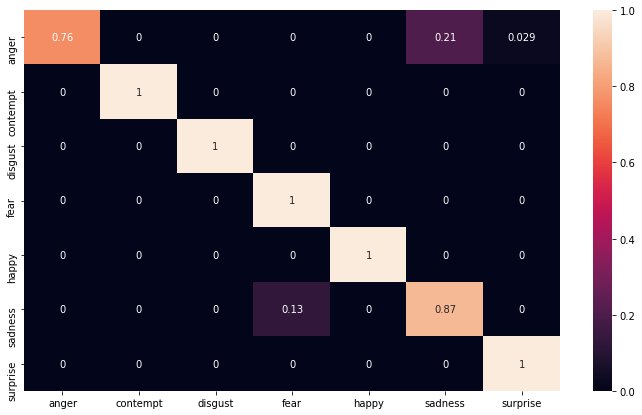

In [ ]:
if __name__ == '__main__':

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print('Training with: ', device)
    neural = NeuralNetwork('resnet18', 'SGD', 64,
                      80, 0.1, './resultados',
                      './Dataset-3/CK48', None, None
                     )

    neural.train_model(device)